# TCC

### Importando bibliotecas que serão usadas ao longo do desenvolvimento

In [2]:
import pandas as pd
import requests
import zipfile
import openpyxl
import os
from pathlib import Path
from datetime import datetime
import time
from pathlib import Path
import numpy as np
import re

## 1. Fundos

### 1. a) Pegando informações cadastrais dos fundos e filtrando somente aqueles que são interessantes para a análise (18/08/2025):

In [ ]:
caminho_registro_classe = r"C:\Users\janet\OneDrive\Área de Trabalho\TCC\Dados\registro_classe.csv"

df_registro_classe = pd.read_csv(caminho_registro_classe, sep=";", encoding="ISO-8859-1", engine="python", on_bad_lines="skip")
df_registro_classe = df_registro_classe[
    (df_registro_classe["Situacao"].str.strip() == "Em Funcionamento Normal") & # somente fundos em funcionamento (ativos)
    (df_registro_classe["Classificacao"].str.strip() == "Renda Fixa") & # somente fundos de renda fixa
    (df_registro_classe["Classe_Cotas"].str.strip() == "N") & # somente fundos MASTER
    (df_registro_classe["Exclusivo"].str.strip() == "N") & # excluindo da amostra fundos exclusivos
    (df_registro_classe["Denominacao_Social"].str.contains(r"(cr[eé]dito privado|\\bCP\\b)", case=False, na=False, regex=True)) # pegando apenas fundos de crédito privado
]

df_registro_classe = df_registro_classe[['CNPJ_Classe', 'Data_Constituicao', 'Denominacao_Social']]
df_registro_classe["Data_Constituicao"] = pd.to_datetime(df_registro_classe["Data_Constituicao"], errors="coerce")
df_registro_classe["CNPJ_Classe"] = pd.to_numeric(df_registro_classe["CNPJ_Classe"], errors="coerce")
df_registro_classe = df_registro_classe[df_registro_classe["Data_Constituicao"] <= "2022-01-03"] # excluindo fundos que iniciaram em 2025

df_registro_classe.to_excel("df_registro_classe.xlsx", index=False)

df_registro_classe

### 1. b) Pegandos informações complementares, para obter o gestor do fundos (18/08/2025):

In [ ]:
caminho_registro_fundo = r"C:\Users\janet\OneDrive\Área de Trabalho\TCC\Dados\registro_fundo.csv"

df_registro_fundo = pd.read_csv(caminho_registro_fundo, sep=";", encoding="ISO-8859-1", engine="python", on_bad_lines="skip")
df_registro_fundo = df_registro_fundo[['CNPJ_Fundo', 'Gestor']]
df_registro_fundo["CNPJ_Fundo"] = pd.to_numeric(df_registro_fundo["CNPJ_Fundo"], errors="coerce")
df_registro_fundo = df_registro_fundo[df_registro_fundo["Gestor"] != "SANTANDER DISTRIBUIDORA DE TÍTULOS E VALORES MOBILIÁRIOS S.A."] # excluindo distribuidora do Santander que gerencia muitos fundos de terceiros


df_registro_fundo = df_registro_fundo.drop_duplicates(subset=["CNPJ_Fundo"], keep="first")

df_registro_fundo


### 1. c) Join entre as informações para obter uma tabela consolidada sobre as informações dos fundos selecionados:

In [ ]:
df_registro = pd.merge(df_registro_classe, df_registro_fundo, how = "left", 
                      left_on = ["CNPJ_Classe"], right_on = ["CNPJ_Fundo"])

df_registro = df_registro[df_registro["Gestor"].notna()] # tirando fundos que não tem gestor

df_registro = df_registro[['CNPJ_Classe', 'Data_Constituicao', 'Denominacao_Social', 'Gestor']]

df_registro = df_registro.rename(columns={
    'CNPJ_Classe': 'CNPJ_FUNDO',
    'Denominacao_Social': 'NOME_FUNDO',
    'Data_Constituicao': 'DATA_INICIO',
    'Gestor': 'GESTOR_FUNDO'
})

df_registro

### Salvar arquivo final Consolidado:

In [ ]:
df_registro.to_excel("df_registro.xlsx", index=False)

## 2. Pegando Informações históricas de 2022 e 2024

### 2. a)

In [ ]:
# -*- coding: utf-8 -*-
"""
Consolidador CVM INF_DIARIO Simplificado (2022–2024)

Objetivo: Baixar os informes diários da CVM, tratar a coluna de CNPJ
e salvar tudo em um único arquivo CSV para análise em TCC.

- Baixa os arquivos ZIP de cada mês diretamente para a memória.
- Extrai o CSV de dentro do ZIP.
- Lida com a mudança de nome das colunas pela CVM (ex: de CNPJ_FUNDO para CNPJ_FUNDO_CLASSE).
- Limpa a coluna de CNPJ, removendo pontos, barras e traços.
- Junta os dados de todos os meses em um único DataFrame.
- Salva o resultado final em um arquivo chamado "dados_cvm_consolidados.csv".

Dependências: requests, pandas
Para instalar, use o comando no seu terminal:
pip install requests pandas
"""

import io
import zipfile
import pandas as pd
import requests

# --- Configurações ---

# Anos que desejamos baixar
ANOS = [2022, 2023, 2024]

# URL base para os arquivos da CVM
BASE_URL = "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{ano}{mes}.zip"

# Nome do arquivo de saída
ARQUIVO_SAIDA = "dados_cvm_consolidados.csv"

# Lista para guardar os dados de cada mês antes de juntar tudo
lista_dataframes_mensais = []

print("Iniciando o processo de download e consolidação dos dados da CVM.")
print(f"Período: {ANOS[0]} a {ANOS[-1]}")

# --- Loop principal para baixar e processar os dados ---

# Itera sobre cada ano da lista ANOS
for ano in ANOS:
    # Itera sobre cada mês do ano (de 1 a 12)
    for mes in range(1, 13):
        # Formata o ano e mês com 4 e 2 dígitos (ex: 2022 e 01)
        ano_str = f"{ano:04d}"
        mes_str = f"{mes:02d}"
        
        print(f"Processando dados de: {ano_str}-{mes_str}...")

        # Monta a URL completa para o arquivo do mês/ano corrente
        url = BASE_URL.format(ano=ano_str, mes=mes_str)

        try:
            # 1. Baixar o arquivo ZIP
            # Faz a requisição para a URL e define um timeout de 60 segundos
            resposta = requests.get(url, timeout=60)
            
            # Verifica se o download foi bem-sucedido (código 200)
            if resposta.status_code != 200:
                print(f"  -> Falha ao baixar o arquivo de {ano_str}-{mes_str}. Código: {resposta.status_code}. Pulando...")
                continue

            # 2. Ler o ZIP em memória
            # Cria um objeto de arquivo em memória a partir do conteúdo baixado
            arquivo_zip_em_memoria = io.BytesIO(resposta.content)

            # Abre o arquivo ZIP que está em memória
            with zipfile.ZipFile(arquivo_zip_em_memoria) as zf:
                # Pega o nome do primeiro arquivo CSV dentro do ZIP
                nome_csv = zf.namelist()[0]

                # 3. Ler o CSV com o pandas
                with zf.open(nome_csv) as csv_file:
                    df_mes = pd.read_csv(
                        csv_file,
                        sep=';',          # O separador de colunas é ponto e vírgula
                        encoding='latin1', # Codificação comum em arquivos do governo
                        low_memory=False   # Evita o DtypeWarning
                    )

                    # 4. Padronizar nomes de colunas que a CVM alterou
                    # A CVM mudou 'CNPJ_FUNDO' -> 'CNPJ_FUNDO_CLASSE' e 'TP_FUNDO' -> 'TP_FUNDO_CLASSE'
                    # nos arquivos mais recentes. Este código lida com ambas as situações.
                    colunas_para_renomear = {}
                    if 'CNPJ_FUNDO_CLASSE' in df_mes.columns:
                        colunas_para_renomear['CNPJ_FUNDO_CLASSE'] = 'CNPJ_FUNDO'
                    if 'TP_FUNDO_CLASSE' in df_mes.columns:
                        colunas_para_renomear['TP_FUNDO_CLASSE'] = 'TP_FUNDO'
                    
                    if colunas_para_renomear:
                        df_mes.rename(columns=colunas_para_renomear, inplace=True)
                    
                    # 5. Limpar a coluna de CNPJ
                    # Verifica se a coluna CNPJ_FUNDO existe (seja a original ou a renomeada)
                    if 'CNPJ_FUNDO' in df_mes.columns:
                        # Se existir, remove todos os caracteres que NÃO são dígitos ('\D')
                        df_mes['CNPJ_FUNDO'] = df_mes['CNPJ_FUNDO'].str.replace(r'\D', '', regex=True)
                    else:
                        # Se nenhuma das colunas de CNPJ for encontrada, avisa e pula o mês
                        print(f"  -> ERRO: Coluna de CNPJ não encontrada no arquivo de {ano_str}-{mes_str}. Pulando...")
                        continue

                    # 6. Adicionar o DataFrame do mês à lista
                    lista_dataframes_mensais.append(df_mes)
                    print(f"  -> Dados de {ano_str}-{mes_str} processados com sucesso.")

        except requests.exceptions.RequestException as e:
            print(f"  -> Erro de conexão ao tentar baixar {url}. Erro: {e}. Pulando...")
        except Exception as e:
            print(f"  -> Ocorreu um erro inesperado ao processar {ano_str}-{mes_str}. Erro: {e}. Pulando...")

# --- Consolidação e Salvamento ---

if lista_dataframes_mensais:
    print("\nJuntando todos os dados em um único arquivo...")
    
    # Concatena (junta) todos os DataFrames da lista em um só
    df_final = pd.concat(lista_dataframes_mensais, ignore_index=True)

    print(f"Salvando o arquivo consolidado como '{ARQUIVO_SAIDA}'...")
    
    # Salva o DataFrame final em um arquivo CSV, sem o índice do pandas
    df_final.to_csv(ARQUIVO_SAIDA, index=False)

    print("\nProcesso concluído com sucesso!")
    print(f"Os dados de {ANOS[0]}-{ANOS[-1]} estão salvos em '{ARQUIVO_SAIDA}'.")
else:
    print("\nNenhum dado foi baixado. O arquivo final não foi gerado.")



### 2. b)

In [ ]:
df_final

## 3. Join entre os dados cadastrais dos fundos e o histórico de Cota e PL

### 3.a) Join entre os dados cadastrais dos fundos e o histórico de Cota e PL

In [ ]:
df_registro

In [ ]:
import pandas as pd
import re

# 1) Garanta que a coluna de chave exista com o mesmo nome nos dois DFs
if "CNPJ" in df_registro.columns and "CNPJ_FUNDO" not in df_registro.columns:
    df_registro = df_registro.rename(columns={"CNPJ": "CNPJ_FUNDO"})

# 2) Função de normalização (só dígitos + zfill 14)
def norm_cnpj_col(s: pd.Series) -> pd.Series:
    # transforma em string, remove tudo que não for dígito e preenche até 14
    s = s.astype("string")
    s = s.str.replace(r"\D", "", regex=True)
    s = s.str.zfill(14).str.slice(0, 14)
    return s

# 3) Aplique nos dois DataFrames (in place)
df_registro["CNPJ_FUNDO"] = norm_cnpj_col(df_registro["CNPJ_FUNDO"])
df_final["CNPJ_FUNDO"]    = norm_cnpj_col(df_final["CNPJ_FUNDO"])

# (opcional, mas recomendado) evite duplicidades no cadastro
df_registro = df_registro.drop_duplicates(subset=["CNPJ_FUNDO"])

# 4) Faça o merge validando o relacionamento esperado
# se df_registro tem 1 linha por CNPJ e df_final tem muitas por CNPJ (histórico diário),
# use validate='one_to_many' para proteger contra surpresas
df_fundos_final = pd.merge(
    df_registro,
    df_final,
    how="left",
    on="CNPJ_FUNDO"
)

# 5) Checagens rápidas
print(df_fundos_final.dtypes["CNPJ_FUNDO"])
print(df_fundos_final["CNPJ_FUNDO"].str.len().value_counts().head())
print(df_fundos_final.head())


In [ ]:
df_fundos_final

In [ ]:
df_fundos_final["CAPTACAO_LIQ"] = df_fundos_final["CAPTC_DIA"] - df_fundos_final["RESG_DIA"]

df_fundos_final = df_fundos_final.rename(columns={
    "DT_COMPTC": "DATA",
    "VL_PATRIM_LIQ": "PL",
    "VL_QUOTA": "COTA",
    "CAPTC_DIA": "CAPTACAO",
    "RESG_DIA": "RESGATE",
    "DATA_INICIO": "DATA_INICIO_FUNDO",
    "NR_COTST": "COTISTAS"
})[["DATA", "CNPJ_FUNDO", "NOME_FUNDO", "DATA_INICIO_FUNDO", "GESTOR_FUNDO", "PL", "COTA", "CAPTACAO", "RESGATE", "CAPTACAO_LIQ", "COTISTAS"]]

df_fundos_final

### 3.b) Retorno diário do fundo  

In [ ]:
# ordenar para evitar erros
df_fundos_final = df_fundos_final.sort_values(["CNPJ_FUNDO", "DATA"])

# calcular retorno diário por fundo
df_fundos_final["RETORNO_DIARIO_FUNDO"] = df_fundos_final.groupby("CNPJ_FUNDO")["COTA"].pct_change()

In [ ]:
df_fundos_final

### 3.c) Retorno diário do CDI e taxa selic e join

In [ ]:
df_bench = pd.read_excel(r"C:\Users\janet\OneDrive\Área de Trabalho\TCC\Dados\di_b3.xlsx")
df_bench["Data"] = pd.to_datetime(df_bench["Data"], errors="coerce")
df_bench = df_bench.rename(columns={"Data": "DATA", "Fator Diário": "CDI_DIARIO", "Taxa SELIC": "SELIC"})
df_bench

df_bench.to_excel("df_bench.xlsx", index=False)

In [ ]:
df_fundos_final["DATA"] = pd.to_datetime(df_fundos_final["DATA"], errors="coerce")
df_fundos_final = df_fundos_final.merge(df_bench, how="left", on="DATA")
df_fundos_final

In [ ]:
df_fundos_final.to_excel("df_fundos_final.xlsx", index=False)

--- evitar rodar tudo novamente ---

In [3]:
df_fundos_final = pd.read_excel(r"C:\Users\janet\OneDrive\Área de Trabalho\TCC\Códigos\df_fundos_final.xlsx")
df_fundos_final["DATA"] = pd.to_datetime(df_fundos_final["DATA"], errors="coerce")
df_fundos_final

,DATA,CNPJ_FUNDO,NOME_FUNDO,DATA_INICIO_FUNDO,GESTOR_FUNDO,PL,COTA,CAPTACAO,RESGATE,CAPTACAO_LIQ,COTISTAS,RETORNO_DIARIO_FUNDO,CDI_DIARIO,SELIC
0,2022-01-03,3233076000155,PORTO SEGURO EMPRESARIAL RENDA FIXA FUNDO DE I...,2005-11-03,PORTO SEGURO GESTORA DE RECURSOS LTDA.,9.577768e+08,3.207042,8550000.0,0.00,8550000.00,15,NaN,1.000347,9.15
1,2022-01-04,3233076000155,PORTO SEGURO EMPRESARIAL RENDA FIXA FUNDO DE I...,2005-11-03,PORTO SEGURO GESTORA DE RECURSOS LTDA.,9.625949e+08,3.208777,4300000.0,0.00,4300000.00,15,0.000541,1.000347,9.15
2,2022-01-05,3233076000155,PORTO SEGURO EMPRESARIAL RENDA FIXA FUNDO DE I...,2005-11-03,PORTO SEGURO GESTORA DE RECURSOS LTDA.,8.704435e+08,3.203706,0.0,90630251.98,-90630251.98,15,-0.001580,1.000347,9.15
3,2022-01-06,3233076000155,PORTO SEGURO EMPRESARIAL RENDA FIXA FUNDO DE I...,2005-11-03,PORTO SEGURO GESTORA DE RECURSOS LTDA.,8.649017e+08,3.205063,7600000.0,13510446.74,-5910446.74,15,0.000423,1.000347,9.15
4,2022-01-07,3233076000155,PORTO SEGURO EMPRESARIAL RENDA FIXA FUNDO DE I...,2005-11-03,PORTO SEGURO GESTORA DE RECURSOS LTDA.,9.353192e+08,3.208867,86906159.0,17515426.91,69390732.09,15,0.001187,1.000347,9.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61749,2024-12-24,97532707000180,RT INDEPENDENCE LDI FUNDO DE INVESTIMENTO FINA...,2011-06-21,ITAU UNIBANCO ASSET MANAGEMENT LTDA.,2.744223e+08,39.830858,0.0,0.00,0.00,1,0.000575,1.000455,12.15
61750,2024-12-26,97532707000180,RT INDEPENDENCE LDI FUNDO DE INVESTIMENTO FINA...,2011-06-21,ITAU UNIBANCO ASSET MANAGEMENT LTDA.,2.745915e+08,39.855415,0.0,0.00,0.00,1,0.000617,1.000455,12.15
61751,2024-12-27,97532707000180,RT INDEPENDENCE LDI FUNDO DE INVESTIMENTO FINA...,2011-06-21,ITAU UNIBANCO ASSET MANAGEMENT LTDA.,2.744716e+08,39.838008,0.0,0.00,0.00,1,-0.000437,1.000455,12.15
61752,2024-12-30,97532707000180,RT INDEPENDENCE LDI FUNDO DE INVESTIMENTO FINA...,2011-06-21,ITAU UNIBANCO ASSET MANAGEMENT LTDA.,2.739642e+08,39.764359,0.0,0.00,0.00,1,-0.001849,1.000455,12.15


### 4. Pegando top e bottom gestoras (PL 31/12/2024) e depois fazendo o join com seus fundos correspondentes

In [4]:
# exemplo: df_fundos_final tem colunas ["DATA", "GESTOR_FUNDO", "PL"]
# filtro pelo dia desejado
df_dia = df_fundos_final[df_fundos_final["DATA"] == "2024-12-31"]

# agrega o PL por gestor (caso tenha mais de um fundo por gestor)
pl_por_gestor = (
    df_dia.groupby("GESTOR_FUNDO", dropna=False)["PL"]
          .sum()
          .reset_index()
          .sort_values("PL", ascending=False)
)

# top 10 maiores
top10 = pl_por_gestor.head(10)

# top 10 menores
bottom10 = pl_por_gestor[pl_por_gestor["PL"] > 0].tail(10)

# print("TOP 10 Gestores por PL em 2024-12-31")
# print(top10)

# print("BOTTOM 10 Gestores por PL em 2024-12-31")
# print(bottom10)

top10.to_excel("top10_gestores_2024-12-31.xlsx", index=False)
bottom10.to_excel("bottom10_gestores_2024-12-31.xlsx", index=False)


In [5]:
# pega a lista única de gestores do top10
gestores_top10 = top10["GESTOR_FUNDO"].unique()

# filtra df_fundos_final mantendo só fundos desses gestores
df_top10_fundos = df_fundos_final[df_fundos_final["GESTOR_FUNDO"].isin(gestores_top10)]

df_top10_fundos.to_excel("df_top10_fundos.xlsx", index=False)

In [ ]:
df_top10_fundos

In [6]:
# pega a lista única de gestores do top10
gestores_bottom10 = bottom10["GESTOR_FUNDO"].unique()

# filtra df_fundos_final mantendo só fundos desses gestores
df_bottom10_fundos = df_fundos_final[df_fundos_final["GESTOR_FUNDO"].isin(gestores_bottom10)]

df_bottom10_fundos.to_excel("df_bottom10_fundos.xlsx", index=False)


In [ ]:
df_bottom10_fundos

## 5. Análise

### 5.a) TOP 10

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_top10 = df_top10_fundos.copy()
df_top10["DATA"] = pd.to_datetime(df_top10["DATA"])

# ==== Funções auxiliares ====
def cdi_series_from_df(df_any):
    return (df_any.groupby("DATA")["CDI_DIARIO"].first().sort_index())

def agg_pl_weighted(df):
    g = (df.groupby("DATA")
           .apply(lambda x: pd.Series({
               "ret_pl": (x["RETORNO_DIARIO_FUNDO"].fillna(0) * x["PL"]).sum() / x["PL"].sum()
                          if x["PL"].sum() > 0 else 0.0,
               "pl_total": x["PL"].sum(),
               "capliq_total": x["CAPTACAO_LIQ"].sum()
            #    "n_fundos": x["CNPJ_FUNDO"].nunique(),
            #    "n_assets": x["GESTOR_FUNDO"].nunique()
           }))
           .reset_index()
           .sort_values("DATA"))
    return g

def to_base100_from_returns(r):
    return (1 + r.fillna(0)).cumprod() * 100

def drawdown_from_returns(r):
    curve = (1 + r.fillna(0)).cumprod()
    peak = curve.cummax()
    return curve/peak - 1

def risk_block(r_group, r_bench):
    r = r_group.dropna()
    vol_ann = r.std() * np.sqrt(252)
    dd = drawdown_from_returns(r).min()
    ret_ann = (1 + r).prod()**(252/len(r)) - 1
    bench_ann = (1 + r_bench.loc[r.index]).prod()**(252/len(r)) - 1
    sharpe = (ret_ann - bench_ann) / vol_ann if vol_ann>0 else np.nan
    ex_ret = r - r_bench.loc[r.index]
    te_ann = ex_ret.std() * np.sqrt(252)
    info_ratio = (ret_ann - bench_ann) / te_ann if te_ann>0 else np.nan
    return pd.Series({
        "ret_ann": ret_ann,
        "bench_ann": bench_ann,
        "vol_ann": vol_ann,
        "max_drawdown": dd,
        "sharpe_vs_cdi": sharpe,
        "info_ratio": info_ratio,
        "tracking_error": te_ann
    })


C:\Users\janet\AppData\Local\Temp\ipykernel_11840\1131427598.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


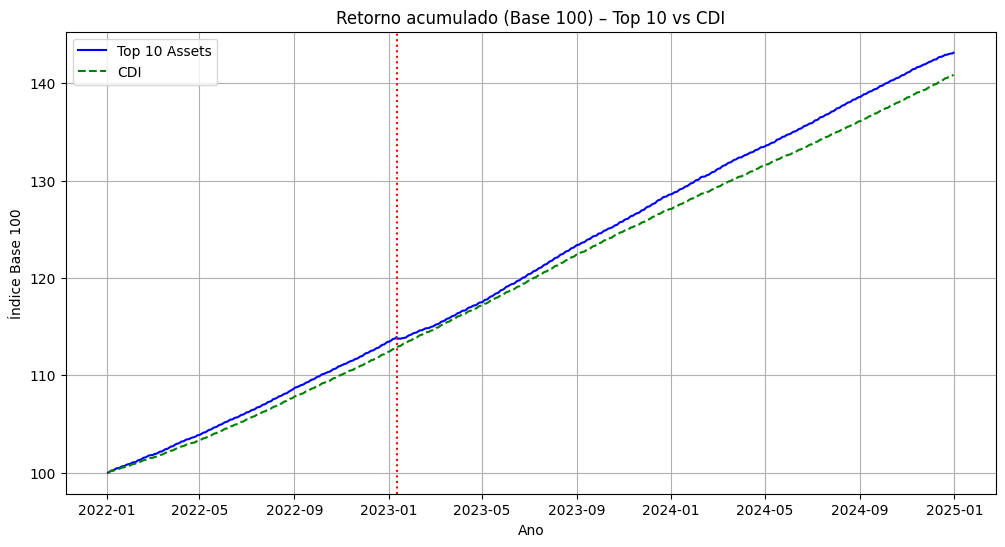

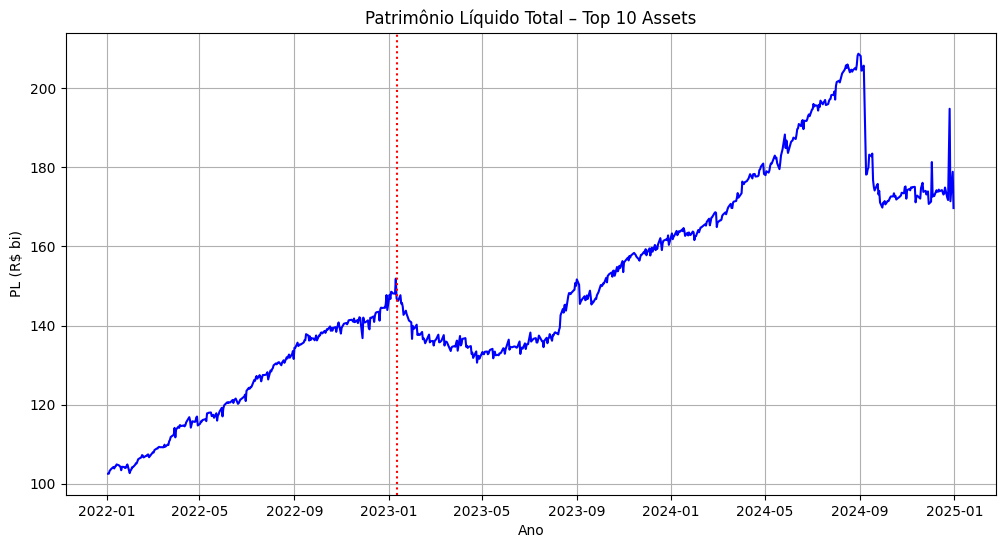

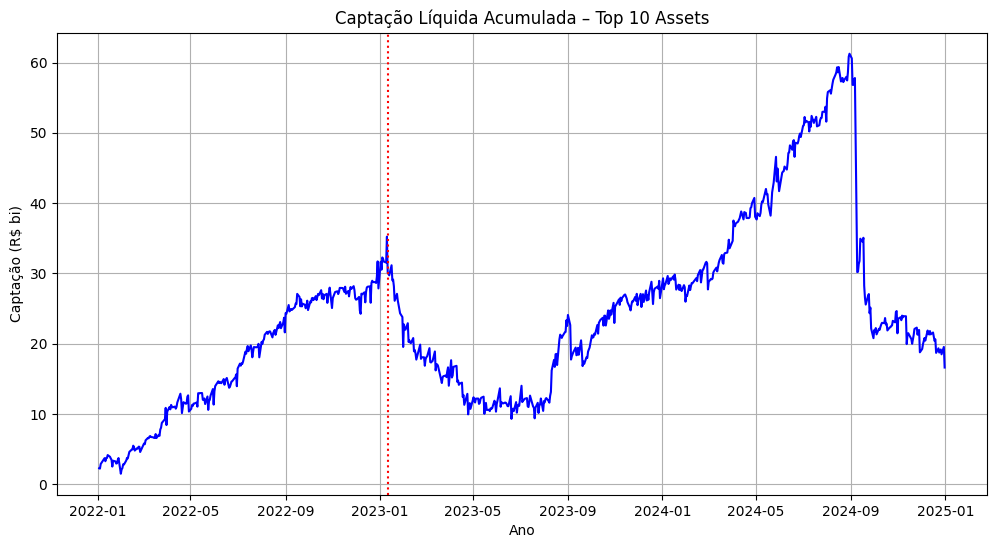

In [8]:
agg10_top = agg_pl_weighted(df_top10)
cdi = cdi_series_from_df(df_top10)

# Retorno acumulado (Base 100)
top10_base100 = to_base100_from_returns(agg10_top["ret_pl"])
cdi_base100 = cdi.cumprod() * 100

plt.figure(figsize=(12,6))
plt.plot(agg10_top["DATA"], top10_base100, label="Top 10 Assets", color="blue")
plt.plot(cdi_base100.index, cdi_base100.values, label="CDI", color="green", linestyle="--")
plt.title("Retorno acumulado (Base 100) – Top 10 vs CDI")
plt.xlabel("Ano"); plt.ylabel("Índice Base 100")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.legend(); plt.grid(True)
plt.show()

# PL
plt.figure(figsize=(12,6))
plt.plot(agg10_top["DATA"], agg10_top["pl_total"]/1e9, color="blue")
plt.title("Patrimônio Líquido Total – Top 10 Assets")
plt.xlabel("Ano"); plt.ylabel("PL (R$ bi)")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.grid(True); plt.show()

# Captação acumulada
agg10_top["capliq_acum_bi"] = agg10_top["capliq_total"].cumsum()/1e9
plt.figure(figsize=(12,6))
plt.plot(agg10_top["DATA"], agg10_top["capliq_acum_bi"], color="blue")
plt.title("Captação Líquida Acumulada – Top 10 Assets")
plt.xlabel("Ano"); plt.ylabel("Captação (R$ bi)")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.grid(True); plt.show()


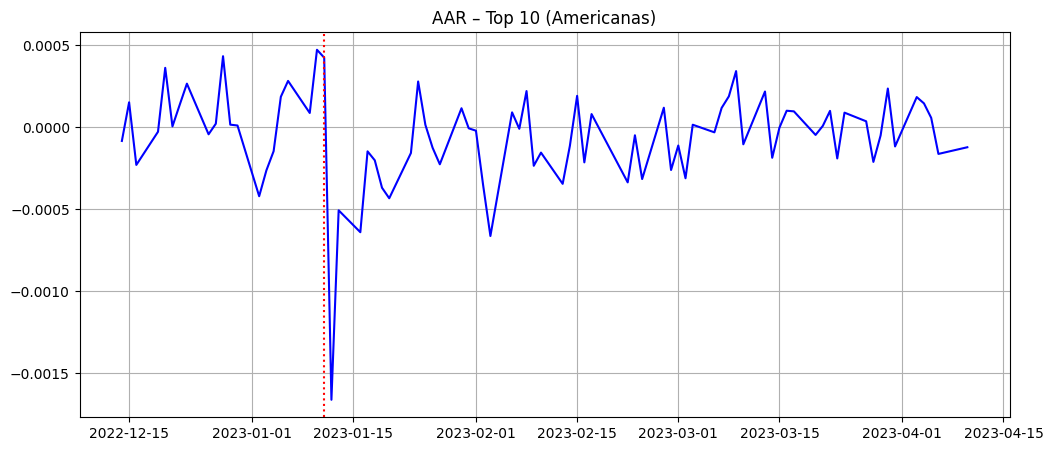

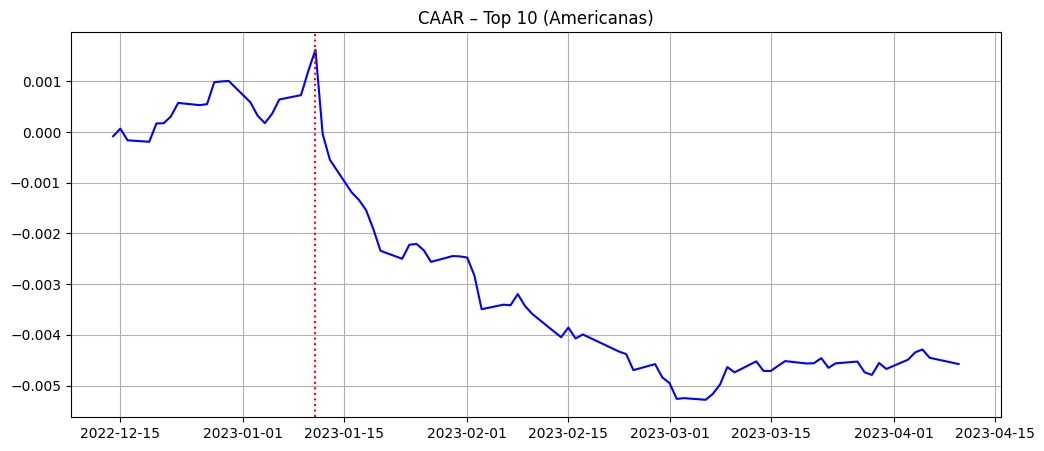

In [9]:
EVENT_DATE = pd.Timestamp("2023-01-11")
PRE, POST = 20, 60

def event_window_index(dates, event_date, pre, post):
    dates = pd.to_datetime(dates)
    idx_event = dates.searchsorted(event_date)
    i0 = max(0, idx_event - pre)
    i1 = min(len(dates)-1, idx_event + post)
    return i0, i1

def abnormal_returns_by_fund(df_group, cdi_series):
    df = df_group.copy()
    df["r_cdi"] = df["DATA"].map(cdi_series - 1)
    df["AR"] = df["RETORNO_DIARIO_FUNDO"].fillna(0) - df["r_cdi"].fillna(0)
    return df[["DATA","CNPJ_FUNDO","AR"]]

def aar_caar(df_group, cdi_series, event_date, pre, post):
    ar_long = abnormal_returns_by_fund(df_group, cdi_series)
    agg = (ar_long.groupby("DATA")["AR"]
                 .agg(['mean','std','count'])
                 .rename(columns={'mean':'AAR','std':'SD','count':'N'})
                 .sort_index())
    i0, i1 = event_window_index(agg.index, event_date, pre, post)
    win = agg.iloc[i0:i1+1].copy()
    win["t_AAR"] = win["AAR"] / (win["SD"]/np.sqrt(win["N"])).replace(0,np.nan)
    win["CAAR"] = win["AAR"].cumsum()
    return win

win20 = aar_caar(df_top10, cdi, EVENT_DATE, PRE, POST)

# Gráficos
plt.figure(figsize=(12,5))
plt.plot(win20.index, win20["AAR"], color="blue")
plt.axvline(EVENT_DATE, linestyle=":", color="red", label="Evento")
plt.title("AAR – Top 10 (Americanas)")
plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(win20.index, win20["CAAR"], color="blue")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.title("CAAR – Top 10 (Americanas)")
plt.grid(True); plt.show()


In [10]:
r_top10 = agg10_top.set_index("DATA")["ret_pl"]
r_cdi = (cdi - 1).reindex(r_top10.index).fillna(method="ffill")

risk_top10 = risk_block(r_top10, r_cdi)
risk_top10


C:\Users\janet\AppData\Local\Temp\ipykernel_11840\311126502.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_cdi = (cdi - 1).reindex(r_top10.index).fillna(method="ffill")


ret_ann           0.127477
bench_ann         0.121495
vol_ann           0.002090
max_drawdown     -0.001551
sharpe_vs_cdi     2.862731
info_ratio        2.938402
tracking_error    0.002036
dtype: float64

### 5.b) BOTTOM 10

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_bottom10 = df_bottom10_fundos.copy()
df_bottom10["DATA"] = pd.to_datetime(df_bottom10["DATA"])

# ==== Funções auxiliares ====
def cdi_series_from_df(df_any):
    return (df_any.groupby("DATA")["CDI_DIARIO"].first().sort_index())

def agg_pl_weighted(df):
    g = (df.groupby("DATA")
           .apply(lambda x: pd.Series({
               "ret_pl": (x["RETORNO_DIARIO_FUNDO"].fillna(0) * x["PL"]).sum() / x["PL"].sum()
                          if x["PL"].sum() > 0 else 0.0,
               "pl_total": x["PL"].sum(),
               "capliq_total": x["CAPTACAO_LIQ"].sum()
            #    "n_fundos": x["CNPJ_FUNDO"].nunique(),
            #    "n_assets": x["GESTOR_FUNDO"].nunique()
           }))
           .reset_index()
           .sort_values("DATA"))
    return g

def to_base100_from_returns(r):
    return (1 + r.fillna(0)).cumprod() * 100

def drawdown_from_returns(r):
    curve = (1 + r.fillna(0)).cumprod()
    peak = curve.cummax()
    return curve/peak - 1

def risk_block(r_group, r_bench):
    r = r_group.dropna()
    vol_ann = r.std() * np.sqrt(252)
    dd = drawdown_from_returns(r).min()
    ret_ann = (1 + r).prod()**(252/len(r)) - 1
    bench_ann = (1 + r_bench.loc[r.index]).prod()**(252/len(r)) - 1
    sharpe = (ret_ann - bench_ann) / vol_ann if vol_ann>0 else np.nan
    ex_ret = r - r_bench.loc[r.index]
    te_ann = ex_ret.std() * np.sqrt(252)
    info_ratio = (ret_ann - bench_ann) / te_ann if te_ann>0 else np.nan
    return pd.Series({
        "ret_ann": ret_ann,
        "bench_ann": bench_ann,
        "vol_ann": vol_ann,
        "max_drawdown": dd,
        "sharpe_vs_cdi": sharpe,
        "info_ratio": info_ratio,
        "tracking_error": te_ann
    })


C:\Users\janet\AppData\Local\Temp\ipykernel_11840\3101399631.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


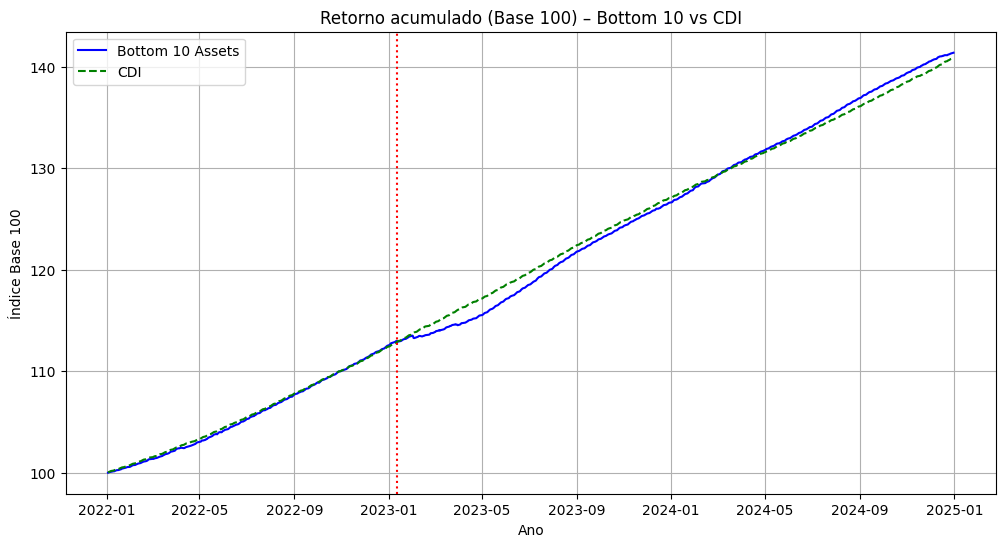

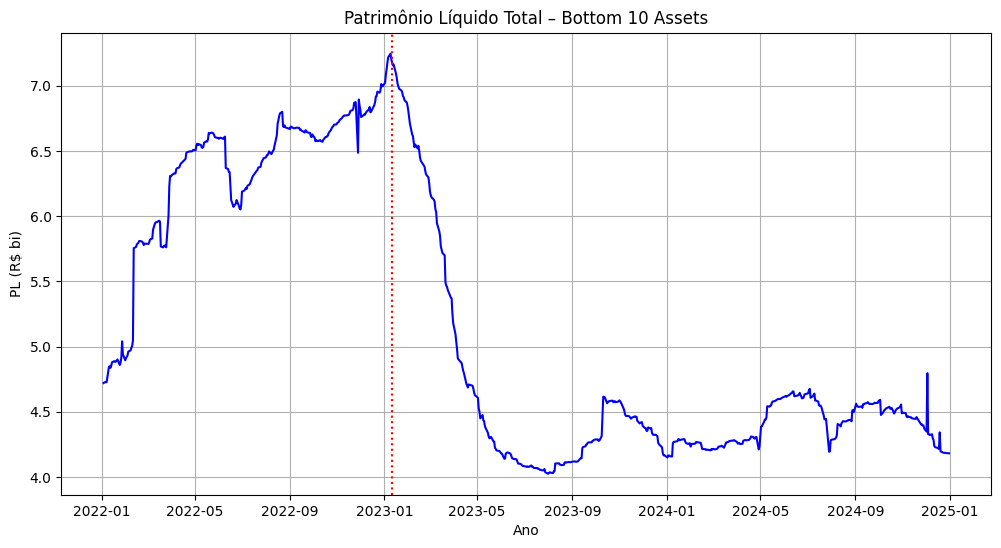

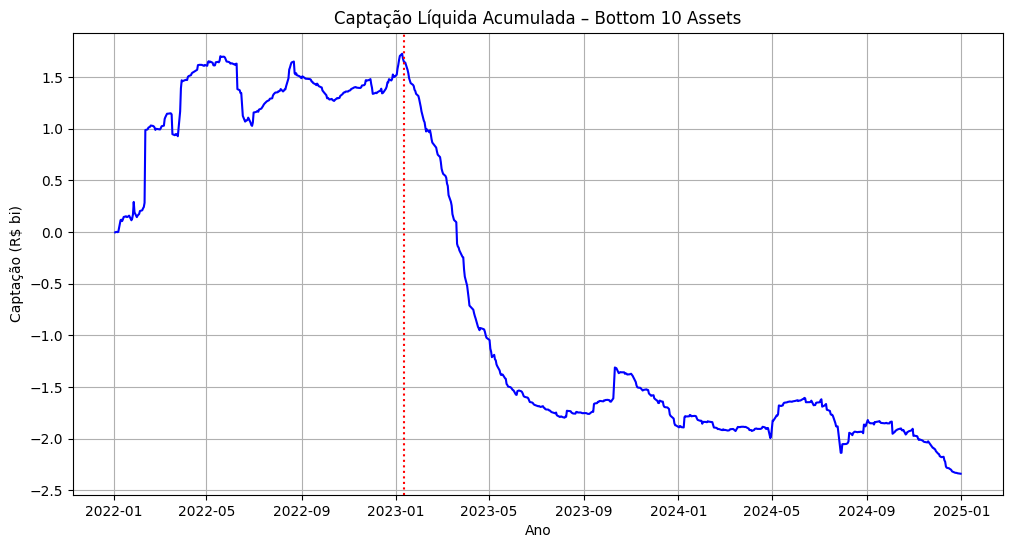

In [12]:
agg10_bottom = agg_pl_weighted(df_bottom10)
cdi = cdi_series_from_df(df_bottom10)

# Retorno acumulado (Base 100)
bottom10_base100 = to_base100_from_returns(agg10_bottom["ret_pl"])
cdi_base100 = cdi.cumprod() * 100

plt.figure(figsize=(12,6))
plt.plot(agg10_bottom["DATA"], bottom10_base100, label="Bottom 10 Assets", color="blue")
plt.plot(cdi_base100.index, cdi_base100.values, label="CDI", color="green", linestyle="--")
plt.title("Retorno acumulado (Base 100) – Bottom 10 vs CDI")
plt.xlabel("Ano"); plt.ylabel("Índice Base 100")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.legend(); plt.grid(True)
plt.show()

# PL
plt.figure(figsize=(12,6))
plt.plot(agg10_bottom["DATA"], agg10_bottom["pl_total"]/1e9, color="blue")
plt.title("Patrimônio Líquido Total – Bottom 10 Assets")
plt.xlabel("Ano"); plt.ylabel("PL (R$ bi)")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.grid(True); plt.show()

# Captação acumulada
agg10_bottom["capliq_acum_bi"] = agg10_bottom["capliq_total"].cumsum()/1e9
plt.figure(figsize=(12,6))
plt.plot(agg10_bottom["DATA"], agg10_bottom["capliq_acum_bi"], color="blue")
plt.title("Captação Líquida Acumulada – Bottom 10 Assets")
plt.xlabel("Ano"); plt.ylabel("Captação (R$ bi)")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.grid(True); plt.show()


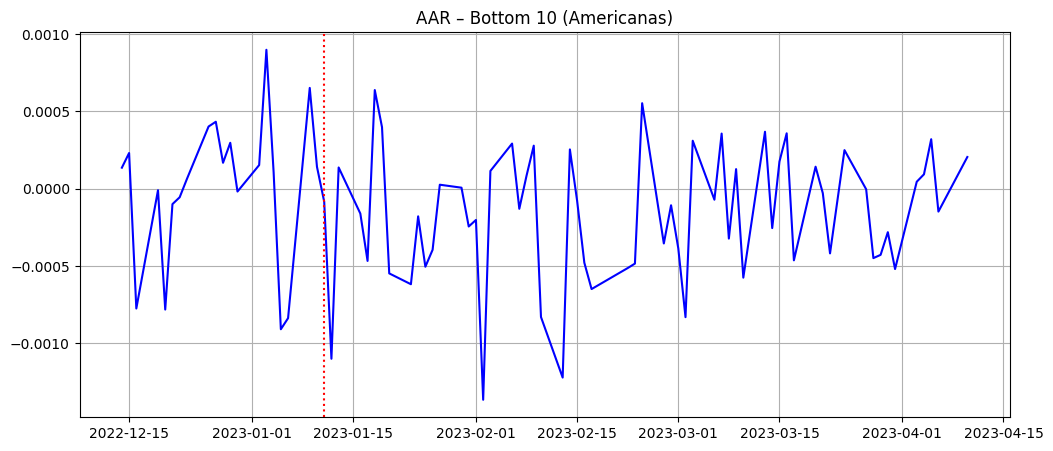

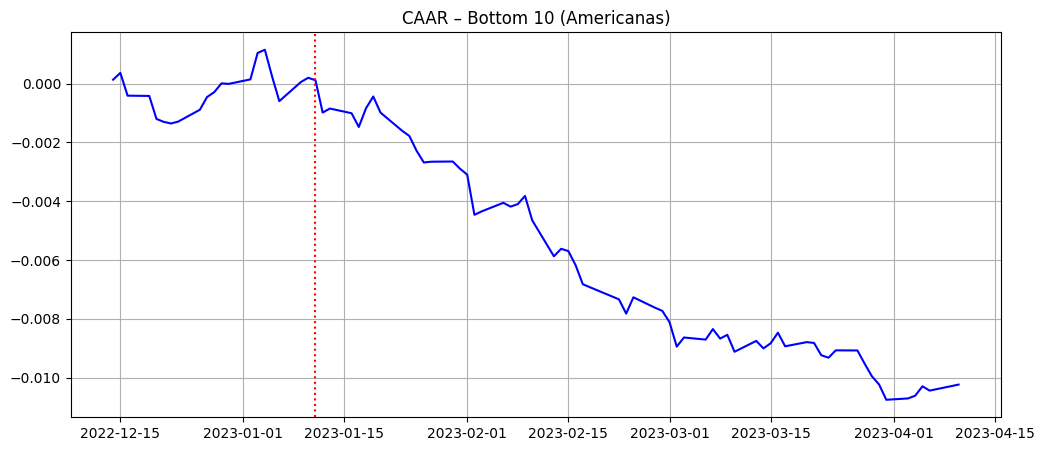

In [13]:
EVENT_DATE = pd.Timestamp("2023-01-11")
PRE, POST = 20, 60

def event_window_index(dates, event_date, pre, post):
    dates = pd.to_datetime(dates)
    idx_event = dates.searchsorted(event_date)
    i0 = max(0, idx_event - pre)
    i1 = min(len(dates)-1, idx_event + post)
    return i0, i1

def abnormal_returns_by_fund(df_group, cdi_series):
    df = df_group.copy()
    df["r_cdi"] = df["DATA"].map(cdi_series - 1)
    df["AR"] = df["RETORNO_DIARIO_FUNDO"].fillna(0) - df["r_cdi"].fillna(0)
    return df[["DATA","CNPJ_FUNDO","AR"]]

def aar_caar(df_group, cdi_series, event_date, pre, post):
    ar_long = abnormal_returns_by_fund(df_group, cdi_series)
    agg = (ar_long.groupby("DATA")["AR"]
                 .agg(['mean','std','count'])
                 .rename(columns={'mean':'AAR','std':'SD','count':'N'})
                 .sort_index())
    i0, i1 = event_window_index(agg.index, event_date, pre, post)
    win = agg.iloc[i0:i1+1].copy()
    win["t_AAR"] = win["AAR"] / (win["SD"]/np.sqrt(win["N"])).replace(0,np.nan)
    win["CAAR"] = win["AAR"].cumsum()
    return win

win20 = aar_caar(df_bottom10, cdi, EVENT_DATE, PRE, POST)

# Gráficos
plt.figure(figsize=(12,5))
plt.plot(win20.index, win20["AAR"], color="blue")
plt.axvline(EVENT_DATE, linestyle=":", color="red", label="Evento")
plt.title("AAR – Bottom 10 (Americanas)")
plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(win20.index, win20["CAAR"], color="blue")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.title("CAAR – Bottom 10 (Americanas)")
plt.grid(True); plt.show()


In [14]:
r_bottom10 = agg10_bottom.set_index("DATA")["ret_pl"]
r_cdi = (cdi - 1).reindex(r_bottom10.index).fillna(method="ffill")

risk_bottom10 = risk_block(r_bottom10, r_cdi)
risk_bottom10


C:\Users\janet\AppData\Local\Temp\ipykernel_11840\4070269501.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_cdi = (cdi - 1).reindex(r_bottom10.index).fillna(method="ffill")


ret_ann           0.122837
bench_ann         0.121495
vol_ann           0.003412
max_drawdown     -0.002174
sharpe_vs_cdi     0.393376
info_ratio        0.398799
tracking_error    0.003366
dtype: float64

### 5.c) Comparando TOP vs BOTTOM

C:\Users\janet\AppData\Local\Temp\ipykernel_11840\3101399631.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
C:\Users\janet\AppData\Local\Temp\ipykernel_11840\3101399631.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


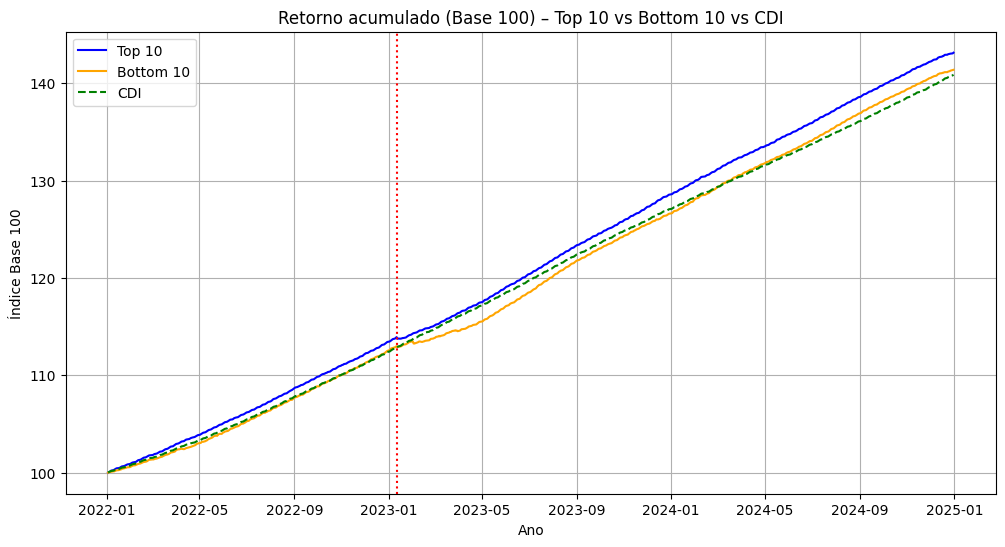

In [15]:
# Retorno acumulado Top vs Bottom
agg_top = agg_pl_weighted(df_top10)   
agg_bot = agg_pl_weighted(df_bottom10)

top_base100 = to_base100_from_returns(agg_top["ret_pl"])
bot_base100 = to_base100_from_returns(agg_bot["ret_pl"])
cdi_base100 = cdi.cumprod() * 100

plt.figure(figsize=(12,6))
plt.plot(agg_top["DATA"], top_base100, label="Top 10", color="blue")
plt.plot(agg_bot["DATA"], bot_base100, label="Bottom 10", color="orange")
plt.plot(cdi_base100.index, cdi_base100.values, label="CDI", color="green", linestyle="--")
plt.title("Retorno acumulado (Base 100) – Top 10 vs Bottom 10 vs CDI")
plt.xlabel("Ano"); plt.ylabel("Índice Base 100")
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.legend(); plt.grid(True)
plt.show()


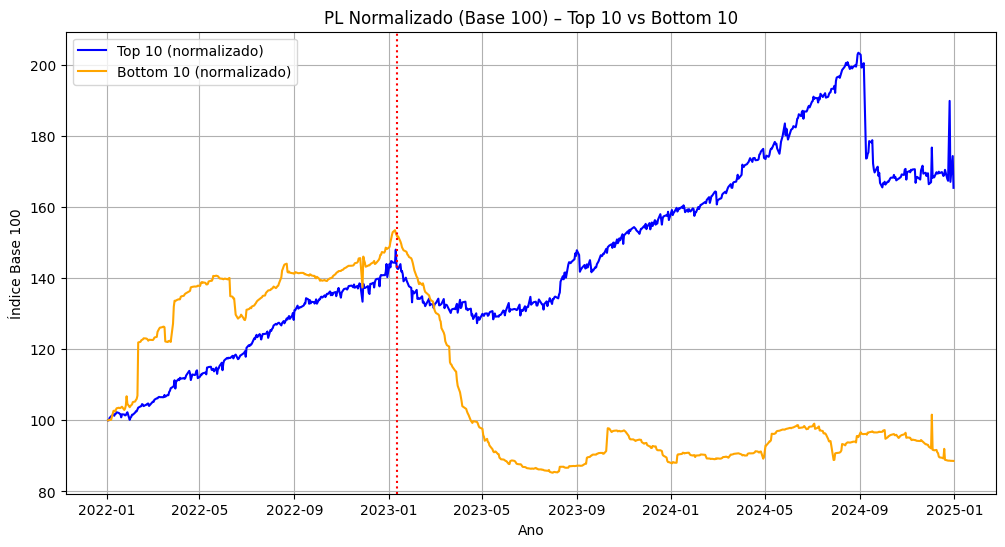

In [16]:
# Normalizar PL (base 100 no início)
pl_top_norm = agg_top["pl_total"] / agg_top["pl_total"].iloc[0] * 100
pl_bot_norm = agg_bot["pl_total"] / agg_bot["pl_total"].iloc[0] * 100

plt.figure(figsize=(12,6))
plt.plot(agg_top["DATA"], pl_top_norm, label="Top 10 (normalizado)", color="blue")
plt.plot(agg_bot["DATA"], pl_bot_norm, label="Bottom 10 (normalizado)", color="orange")
plt.title("PL Normalizado (Base 100) – Top 10 vs Bottom 10")
plt.xlabel("Ano"); plt.ylabel("Índice Base 100")
plt.legend(); plt.grid(True)
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.show()


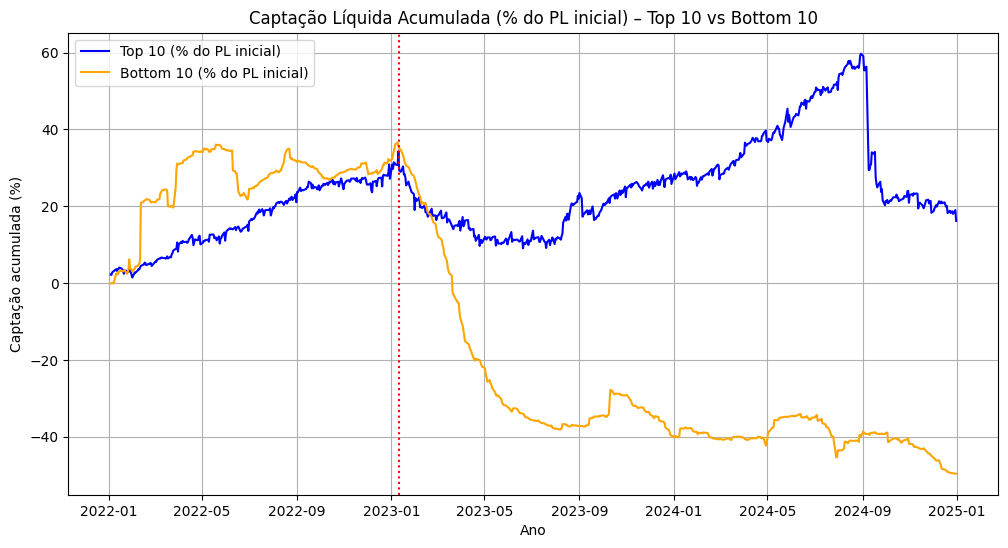

In [17]:
capliq_top_pct = agg_top["capliq_total"].cumsum() / agg_top["pl_total"].iloc[0] * 100
capliq_bot_pct = agg_bot["capliq_total"].cumsum() / agg_bot["pl_total"].iloc[0] * 100

plt.figure(figsize=(12,6))
plt.plot(agg_top["DATA"], capliq_top_pct, label="Top 10 (% do PL inicial)", color="blue")
plt.plot(agg_bot["DATA"], capliq_bot_pct, label="Bottom 10 (% do PL inicial)", color="orange")
plt.title("Captação Líquida Acumulada (% do PL inicial) – Top 10 vs Bottom 10")
plt.xlabel("Ano"); plt.ylabel("Captação acumulada (%)")
plt.legend(); plt.grid(True)
EVENT_DATE = pd.Timestamp("2023-01-11")
plt.axvline(EVENT_DATE, linestyle=":", color="red")
plt.show()


In [18]:
r_top = agg_top.set_index("DATA")["ret_pl"]
r_bot = agg_bot.set_index("DATA")["ret_pl"]
r_cdi = (cdi - 1).reindex(r_top.index).ffill()

risk_top = risk_block(r_top, r_cdi).rename("Top 10")
risk_bot = risk_block(r_bot, r_cdi).rename("Bottom 10")

risk_comparativo = pd.concat([risk_top, risk_bot], axis=1)
print(risk_comparativo)


                  Top 10  Bottom 10
ret_ann         0.127477   0.122837
bench_ann       0.121495   0.121495
vol_ann         0.002090   0.003412
max_drawdown   -0.001551  -0.002174
sharpe_vs_cdi   2.862731   0.393376
info_ratio      2.938402   0.398799
tracking_error  0.002036   0.003366


#### 5.d) Avaliando as gestoras

In [19]:
def aar_caar_por_gestora(df_group, cdi_series, event_date, pre, post):
    ar_long = abnormal_returns_by_fund(df_group, cdi_series)
    results = []

    for gestor, df_gestor in ar_long.groupby(df_group["GESTOR_FUNDO"]):
        agg = (df_gestor.groupby("DATA")["AR"]
                         .agg(['mean'])
                         .rename(columns={'mean':'AAR'})
                         .sort_index())
        # janela
        i0, i1 = event_window_index(agg.index, event_date, pre, post)
        win = agg.iloc[i0:i1+1].copy()
        win["CAAR"] = win["AAR"].cumsum()
        results.append({
            "Gestora": gestor,
            "AAR_evento": win.loc[event_date,"AAR"] if event_date in win.index else np.nan,
            "CAAR_fim": win["CAAR"].iloc[-1]
        })
    return pd.DataFrame(results)


In [32]:
EVENT_DATE = pd.Timestamp("2023-01-11")
PRE, POST = 20, 60

# Top 10
gestoras_top = aar_caar_por_gestora(df_top10, cdi, EVENT_DATE, PRE, POST)

# Bottom 10
gestoras_bot = aar_caar_por_gestora(df_bottom10, cdi, EVENT_DATE, PRE, POST)

# Juntar
gestoras_evento = pd.concat([gestoras_top.assign(Grupo="Top 10"),
                             gestoras_bot.assign(Grupo="Bottom 10")])
gestoras_evento.sort_values("CAAR_fim", inplace=True)
gestoras_evento


,Gestora,AAR_evento,CAAR_fim,Grupo
7,SCHRODER INVESTMENT MANAGEMENT BRASIL LTDA.,-0.003262,-0.040036,Bottom 10
9,VALORA RENDA FIXA LTDA.,0.000097,-0.018805,Bottom 10
8,SPARTA ADMINISTRADORA DE RECURSOS LTDA,0.001376,-0.017724,Top 10
7,SANTANDER BRASIL GESTÃO DE RECURSOS LTDA,0.000034,-0.015001,Top 10
0,AZ QUEST MZK INVESTIMENTOS MACRO E CRÉDITO LTDA.,0.000044,-0.014597,Top 10
9,XP VISTA ASSET MANAGEMENT LTDA.,0.000024,-0.011680,Top 10
4,PORTO SEGURO INVESTIMENTOS LTDA,0.000074,-0.007349,Bottom 10
2,BB GESTAO DE RECURSOS DTVM S.A,0.000040,-0.004612,Top 10
3,PLURAL GESTÃO DE RECURSOS LTDA,0.000710,-0.002740,Bottom 10
5,QLZ GESTÃO DE RECURSOS FINANCEIROS LTDA,0.000015,-0.002703,Bottom 10


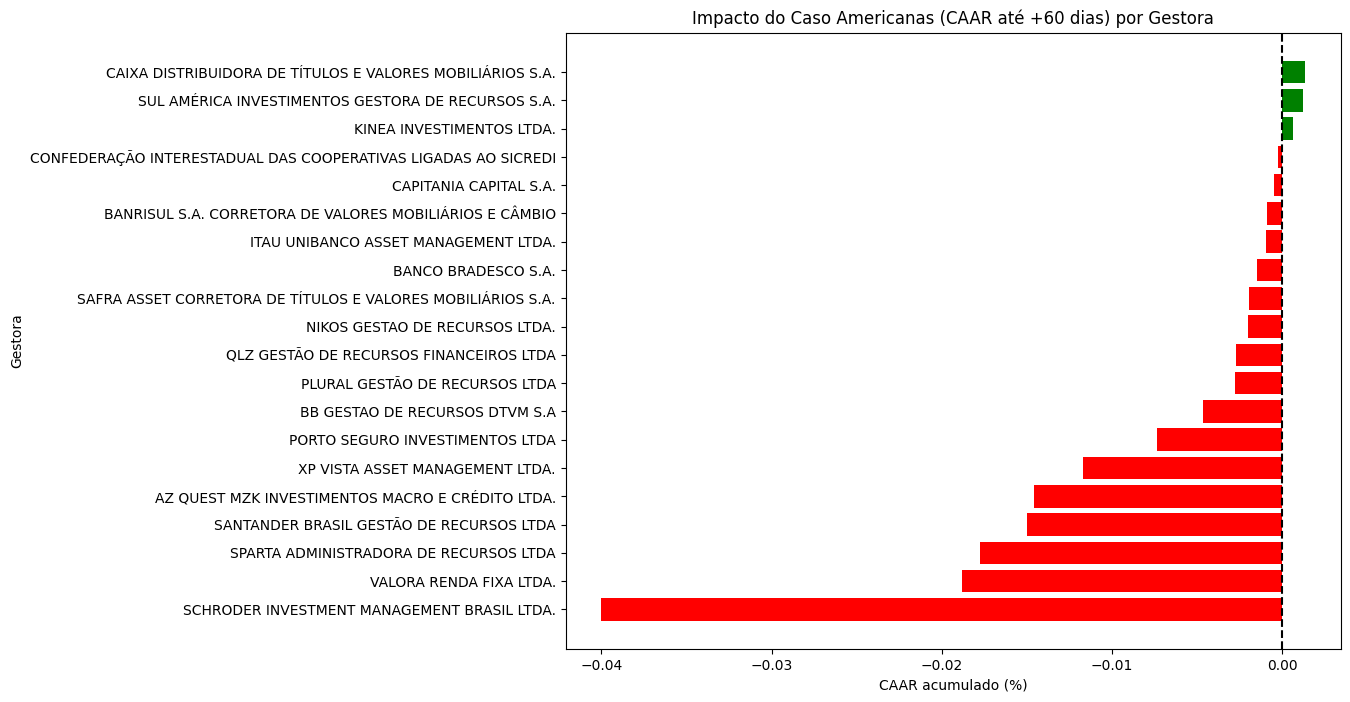

In [33]:
plt.figure(figsize=(10,8))
plt.barh(gestoras_evento["Gestora"], gestoras_evento["CAAR_fim"], color=np.where(gestoras_evento["CAAR_fim"]<0, "red", "green"))
plt.axvline(0, color="black", linestyle="--")
plt.title("Impacto do Caso Americanas (CAAR até +60 dias) por Gestora")
plt.xlabel("CAAR acumulado (%)")
plt.ylabel("Gestora")
plt.show()


In [22]:
def capliq_por_gestora(df, event_date, pre, post):
    # janela de análise
    i0, i1 = event_window_index(df["DATA"].unique(), event_date, pre, post)
    datas = sorted(df["DATA"].unique())
    datas_win = datas[i0:i1+1]

    resultados = []
    for gestor, df_gestor in df.groupby("GESTOR_FUNDO"):
        df_win = df_gestor[df_gestor["DATA"].isin(datas_win)]
        capliq_acum = df_win.groupby("DATA")["CAPTACAO_LIQ"].sum().cumsum()
        resultados.append({
            "Gestora": gestor,
            "Capliq_evento": df_win.loc[df_win["DATA"]==event_date, "CAPTACAO_LIQ"].sum()
                              if event_date in df_win["DATA"].values else 0,
            "Capliq_acum": capliq_acum.iloc[-1] if len(capliq_acum)>0 else 0
        })
    return pd.DataFrame(resultados)


In [34]:
EVENT_DATE = pd.Timestamp("2023-01-11")
PRE, POST = 20, 60

capliq_top = capliq_por_gestora(df_top10, EVENT_DATE, PRE, POST).assign(Grupo="Top 10")
capliq_bot = capliq_por_gestora(df_bottom10, EVENT_DATE, PRE, POST).assign(Grupo="Bottom 10")

capliq_gestoras = pd.concat([capliq_top, capliq_bot])
capliq_gestoras.sort_values("Capliq_acum", inplace=True)
capliq_gestoras


,Gestora,Capliq_evento,Capliq_acum,Grupo
5,ITAU UNIBANCO ASSET MANAGEMENT LTDA.,1.975121e+08,-8.102804e+09,Top 10
0,AZ QUEST MZK INVESTIMENTOS MACRO E CRÉDITO LTDA.,-3.814123e+07,-2.185677e+09,Top 10
1,BANCO BRADESCO S.A.,-4.777962e+09,-1.379683e+09,Top 10
7,SCHRODER INVESTMENT MANAGEMENT BRASIL LTDA.,-7.087673e+06,-1.148017e+09,Bottom 10
7,SANTANDER BRASIL GESTÃO DE RECURSOS LTDA,5.433918e+06,-9.346720e+08,Top 10
2,BB GESTAO DE RECURSOS DTVM S.A,4.066687e+07,-9.204034e+08,Top 10
1,CAPITANIA CAPITAL S.A.,-2.000000e+07,-8.197359e+08,Bottom 10
9,XP VISTA ASSET MANAGEMENT LTDA.,2.125493e+07,-5.288196e+08,Top 10
8,SPARTA ADMINISTRADORA DE RECURSOS LTDA,-8.392810e+05,-3.075268e+08,Top 10
6,SAFRA ASSET CORRETORA DE TÍTULOS E VALORES MOB...,0.000000e+00,-9.634057e+07,Bottom 10


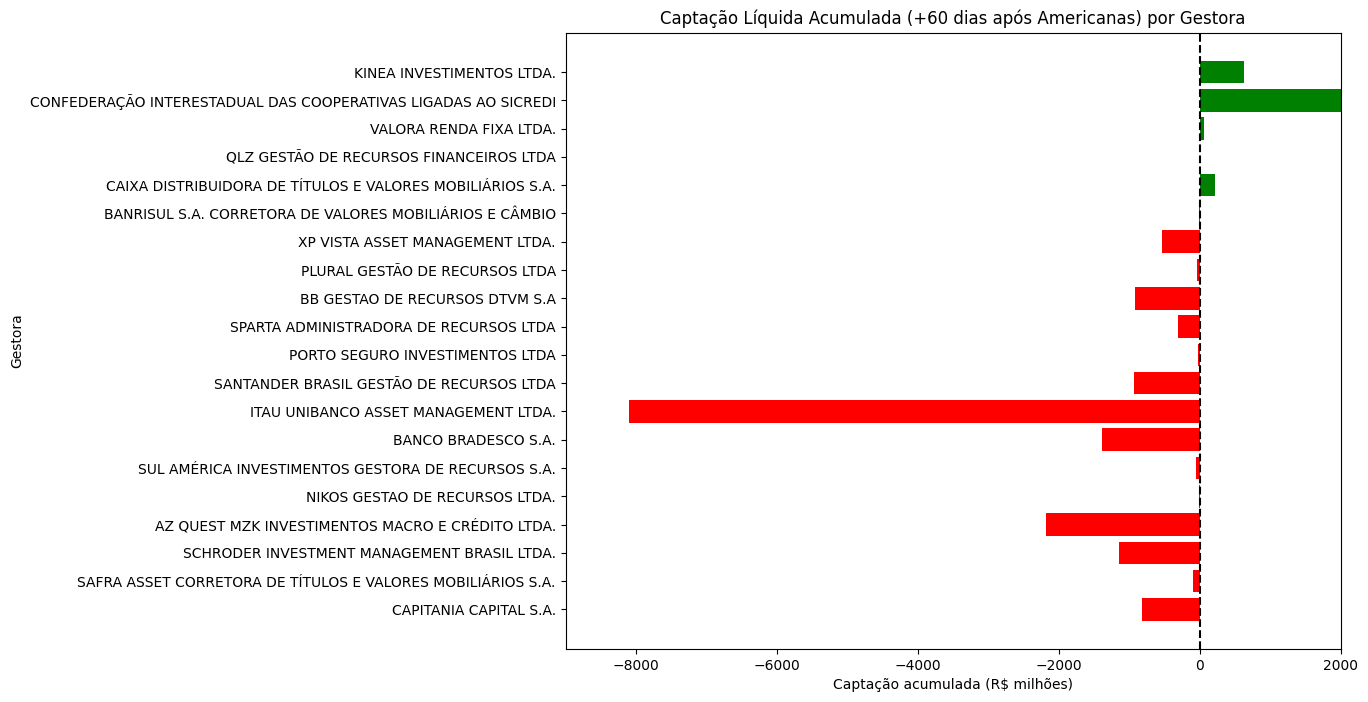

In [38]:
plt.figure(figsize=(10,8))
plt.barh(capliq_gestoras["Gestora"], capliq_gestoras["Capliq_acum"]/1e6,
         color=np.where(capliq_gestoras["Capliq_acum"]<0, "red", "green"))
plt.axvline(0, color="black", linestyle="--")
plt.title("Captação Líquida Acumulada (+60 dias após Americanas) por Gestora")
plt.xlabel("Captação acumulada (R$ milhões)")
plt.ylabel("Gestora")

# Forçar que o eixo mostre pelo menos até -100%
xmin = -9000
xmax = 2000
plt.xlim(xmin, xmax)

plt.show()


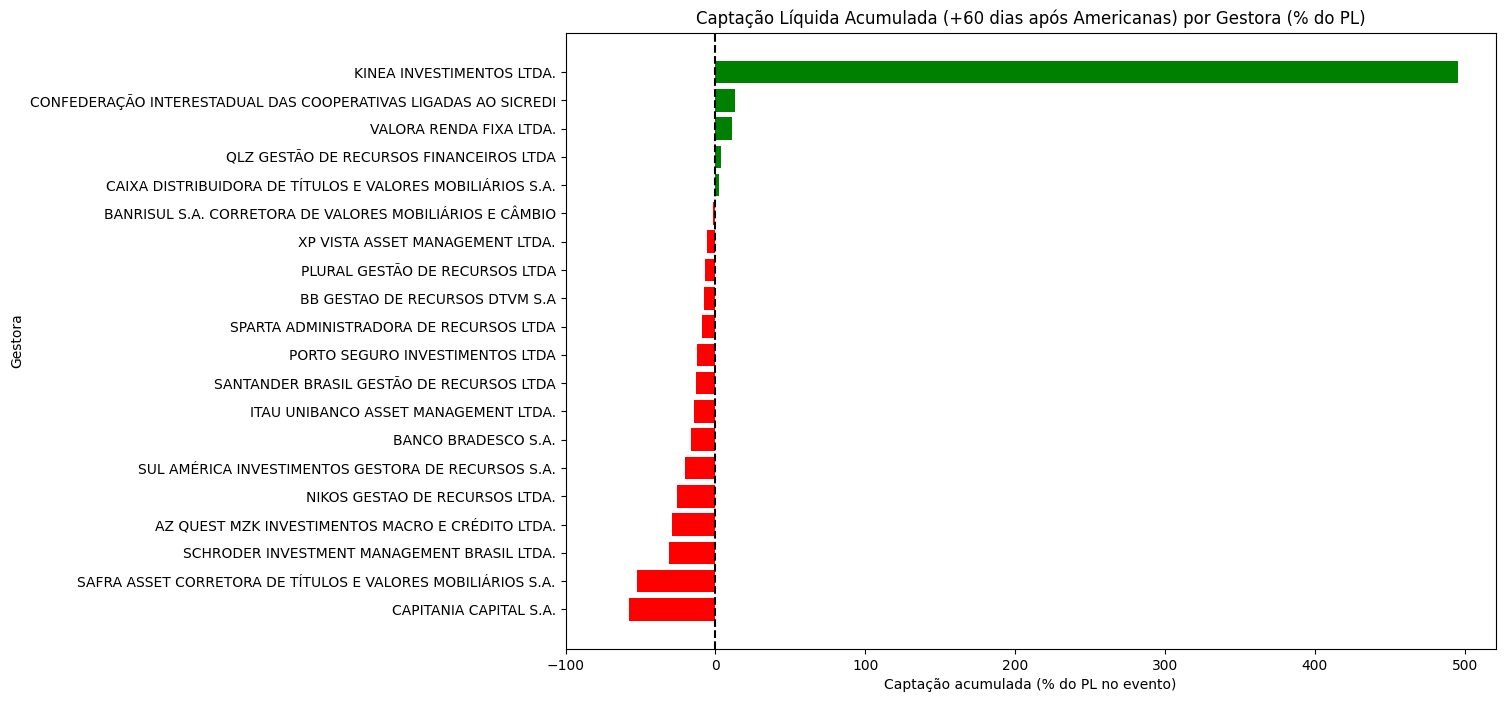

In [37]:
def capliq_por_gestora_pct(df, event_date, pre, post):
    i0, i1 = event_window_index(df["DATA"].unique(), event_date, pre, post)
    datas = sorted(df["DATA"].unique())
    datas_win = datas[i0:i1+1]

    resultados = []
    for gestor, df_gestor in df.groupby("GESTOR_FUNDO"):
        df_win = df_gestor[df_gestor["DATA"].isin(datas_win)]
        capliq_acum = df_win.groupby("DATA")["CAPTACAO_LIQ"].sum().cumsum()

        # PL de referência = PL no dia do evento
        pl_ref = df_gestor.loc[df_gestor["DATA"]==event_date, "PL"].sum()

        resultados.append({
            "Gestora": gestor,
            "Capliq_acum": capliq_acum.iloc[-1] if len(capliq_acum)>0 else 0,
            "PL_ref_evento": pl_ref,
            "Capliq_pctPL": (capliq_acum.iloc[-1]/pl_ref*100) if pl_ref>0 else np.nan
        })
    return pd.DataFrame(resultados)

# Top 10 e Bottom 10
capliq_top = capliq_por_gestora_pct(df_top10, EVENT_DATE, PRE, POST).assign(Grupo="Top 10")
capliq_bot = capliq_por_gestora_pct(df_bottom10, EVENT_DATE, PRE, POST).assign(Grupo="Bottom 10")

capliq_gestoras = pd.concat([capliq_top, capliq_bot])
capliq_gestoras.sort_values("Capliq_pctPL", inplace=True)

# Gráfico em % do PL
plt.figure(figsize=(12,8))
plt.barh(capliq_gestoras["Gestora"], capliq_gestoras["Capliq_pctPL"],
         color=np.where(capliq_gestoras["Capliq_pctPL"]<0, "red", "green"))
plt.axvline(0, color="black", linestyle="--")
plt.title("Captação Líquida Acumulada (+60 dias após Americanas) por Gestora (% do PL)")
plt.xlabel("Captação acumulada (% do PL no evento)")
plt.ylabel("Gestora")

# Forçar que o eixo mostre pelo menos até -100%
xmin = -100
xmax = capliq_gestoras["Capliq_pctPL"].max() * 1.05
plt.xlim(xmin, xmax)

plt.show()





### 6. Significância estatística

In [ ]:
from scipy.stats import ttest_ind

# Reusa seus parâmetros do notebook (ajuste se quiser)
event_date   = globals().get('event_date', '2023-01-11')
pre_window   = globals().get('pre_window', 60)
pos_window   = globals().get('pos_window', 60)
include_day0 = globals().get('include_day0', False)  # True inclui o dia 0 no pós

def _split_pre_pos_from_AR(df_group, label):
    """Gera séries pré e pós a partir do AR já calculado via suas funções."""
    # Usa suas funções já definidas no notebook:
    cdi = cdi_series_from_df(df_group)
    ar_long = abnormal_returns_by_fund(df_group, cdi)  # espera colunas: 'DATA' e 'AR'
    dfx = ar_long[['DATA', 'AR']].dropna().copy()

    dfx['DATA'] = pd.to_datetime(dfx['DATA'])
    ev = pd.to_datetime(event_date)
    rel = (dfx['DATA'] - ev).dt.days

    pre_mask = (rel >= -pre_window) & (rel <= -1)
    pos_lo = 0 if include_day0 else 1
    pos_mask = (rel >= pos_lo) & (rel <=  pos_window)

    pre = dfx.loc[pre_mask, 'AR'].astype(float).to_numpy()
    pos = dfx.loc[pos_mask, 'AR'].astype(float).to_numpy()

    return pre, pos

def teste_simples(df_group, nome):
    pre, pos = _split_pre_pos_from_AR(df_group, nome)

    m_pre = np.nanmean(pre) if pre.size else np.nan
    m_pos = np.nanmean(pos) if pos.size else np.nan
    delta = m_pos - m_pre

    if pre.size > 2 and pos.size > 2:
        _, p_val = ttest_ind(pos, pre, equal_var=False, nan_policy='omit')  # Welch
        conclusao = "significativa (5%)" if p_val < 0.05 else "NÃO significativa (5%)"
    else:
        p_val, conclusao = np.nan, "amostras pequenas (sem teste)"

    print(f"\n=== {nome} ===")
    print(f"Janela: pre=[-{pre_window}, -1], pos=[{'0' if include_day0 else '1'}, +{pos_window}] | "
          f"N pre={pre.size}, N pos={pos.size}")
    print(f"Média pré  : {m_pre:.4%} | Média pós : {m_pos:.4%} | Δ (pós - pré): {delta:.4%}")
    print(f"Welch t-test: p-valor = {p_val:.4f}  →  diferença {conclusao}")

    return {
        "grupo": nome, "n_pre": pre.size, "n_pos": pos.size,
        "media_pre": m_pre, "media_pos": m_pos, "delta": delta,
        "p_valor": p_val, "significativo_5pct": (isinstance(p_val, float) and p_val < 0.05)
    }

# Rode para os dois grupos (já existentes no seu notebook):
res_top    = teste_simples(df_top10,    "Top 10")
res_bottom = teste_simples(df_bottom10, "Bottom 10")

# Tabela curtinha para colar no TCC
display(pd.DataFrame([res_top, res_bottom])[[
    "grupo","n_pre","n_pos","media_pre","media_pos","delta","p_valor","significativo_5pct"
]])



=== Top 10 ===
Janela: pre=[-60, -1], pos=[1, +60] | N pre=2213, N pos=2160
Média pré  : 0.0024% | Média pós : -0.0159% | Δ (pós - pré): -0.0183%
Welch t-test: p-valor = 0.0000  →  diferença significativa (5%)

=== Bottom 10 ===
Janela: pre=[-60, -1], pos=[1, +60] | N pre=734, N pos=720
Média pré  : 0.0018% | Média pós : -0.0231% | Δ (pós - pré): -0.0249%
Welch t-test: p-valor = 0.0564  →  diferença NÃO significativa (5%)


,grupo,n_pre,n_pos,media_pre,media_pos,delta,p_valor,significativo_5pct
0,Top 10,2213,2160,0.000024,-0.000159,-0.000183,8.381711e-12,True
1,Bottom 10,734,720,0.000018,-0.000231,-0.000249,5.636861e-02,False
